# covid19pt-forecasting

Blablabla

## Imports

In [1]:
import pandas as pd
import requests
import json

## Import data from DGS API

### API

In [2]:
response = requests.get("https://covid19-api.vost.pt/Requests/get_full_dataset")

In [3]:
data_dgs = response.json()

In [4]:
data_dgs_df = pd.DataFrame.from_dict(data_dgs)
data_dgs_df['data_dados'] = pd.to_datetime(data_dgs_df.data_dados, infer_datetime_format=True)
data_dgs_df = data_dgs_df.set_index('data_dados').sort_index()


In [5]:
display(data_dgs_df)

,data,confirmados,confirmados_arsnorte,confirmados_arscentro,confirmados_arslvt,confirmados_arsalentejo,confirmados_arsalgarve,confirmados_acores,confirmados_madeira,confirmados_estrangeiro,...,obitos_60_69_m,obitos_70_79_f,obitos_70_79_m,obitos_80_plus_f,obitos_80_plus_m,obitos_f,obitos_m,confirmados_desconhecidos_m,confirmados_desconhecidos_f,ativos
data_dados,,,,,,,,,,,,,,,,,,,,,
2020-02-26,26-02-2020,0,0,0,0,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-27,27-02-2020,0,0,0,0,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-28,28-02-2020,0,0,0,0,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-29,29-02-2020,0,0,0,0,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-01,01-03-2020,0,0,0,0,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-17,17-09-2020,66396,23984,5480,33960,1231,1304,241,196,NaN,...,113.0,148.0,230.0,705.0,554.0,936.0,952.0,NaN,NaN,19714.0
2020-09-18,18-09-2020,67176,24234,5526,34386,1267,1324,241,198,NaN,...,114.0,148.0,230.0,706.0,556.0,938.0,956.0,NaN,NaN,20229.0
2020-09-19,19-09-2020,68025,24522,5592,34825,1283,1359,241,203,NaN,...,114.0,149.0,230.0,708.0,558.0,941.0,958.0,NaN,NaN,20722.0


# Confirmed cases only

In [6]:
data_dgs_df_confirmed = data_dgs_df[['confirmados']]
# add missing days
all_days = pd.date_range(data_dgs_df_confirmed.index.min(), data_dgs_df_confirmed.index.max(), freq='D')
data_dgs_df_confirmed.reindex(all_days)

#data_dgs_df_confirmed = data_dgs_df_confirmed[data_dgs_df_confirmed['confirmados'] != 0] # drop days without information
display(data_dgs_df_confirmed)

,confirmados
data_dados,
2020-02-26,0
2020-02-27,0
2020-02-28,0
2020-02-29,0
2020-03-01,0
...,...
2020-09-17,66396
2020-09-18,67176
2020-09-19,68025


## Timeseries magic

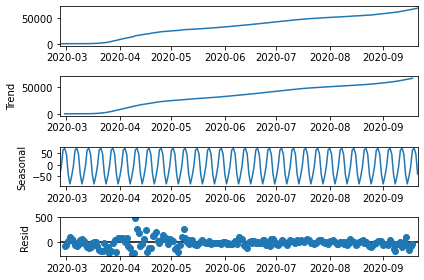

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

data_dgs_df_confirmed = data_dgs_df_confirmed.asfreq('d')
data_dgs_df_confirmed = data_dgs_df_confirmed.fillna(method='bfill').fillna(method='ffill')

decomposition = seasonal_decompose(data_dgs_df_confirmed,  model='additive') #period = 30 WHAT DOES PERIOD DO?
decomposition.plot()
plt.show() 

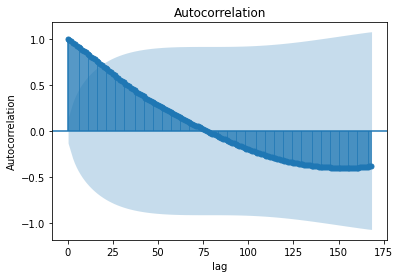

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data_dgs_df_confirmed, alpha=0.05, lags=24*7)
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

### Make data stationary

In [9]:
data_dgs_df_confirmed_detrend = data_dgs_df_confirmed.diff().dropna()

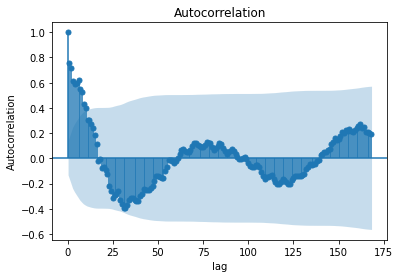

In [10]:
plot_acf(data_dgs_df_confirmed_detrend, alpha=0.05, lags=24*7)
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

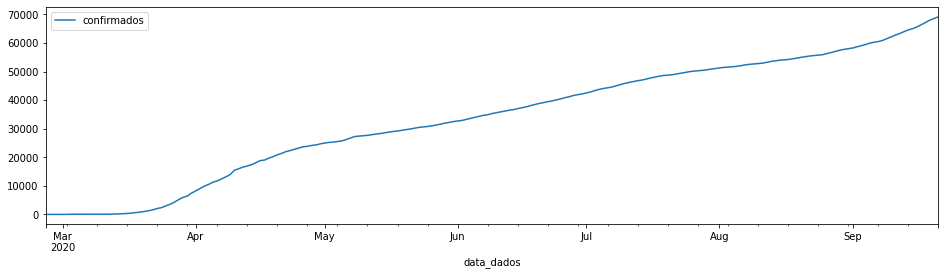

In [11]:
data_dgs_df_confirmed.plot(figsize=(16, 4));

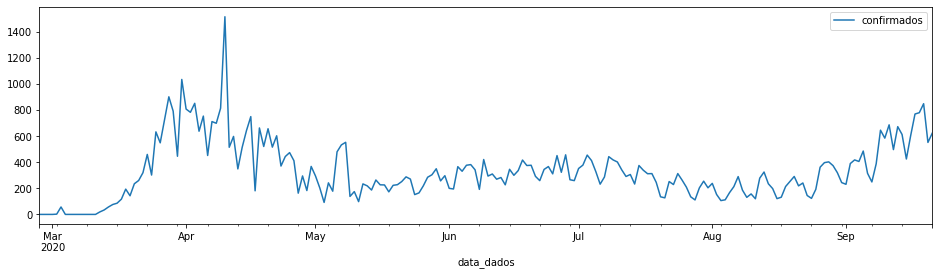

In [12]:
data_dgs_df_confirmed_detrend.plot(figsize=(16, 4));

In [14]:
import pmdarima as pm

sarimax = pm.AutoARIMA(seasonal=True, trace=True, supress_warnings=True, method='nm', maxiter=100)
sarimax.fit(data_dgs_df_confirmed_detrend)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2635.632, Time=0.17 sec


/Users/inesmendes/miniconda3/envs/forecast/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2841.144, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2664.903, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2758.206, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3084.487, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2635.381, Time=0.13 sec


/Users/inesmendes/miniconda3/envs/forecast/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/inesmendes/miniconda3/envs/forecast/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=2699.039, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2633.758, Time=0.17 sec


/Users/inesmendes/miniconda3/envs/forecast/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/inesmendes/miniconda3/envs/forecast/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2637.546, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2638.732, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2635.163, Time=0.09 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 1.373 seconds


/Users/inesmendes/miniconda3/envs/forecast/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


AutoARIMA(maxiter=100, method='nm', trace=True)

/Users/inesmendes/miniconda3/envs/forecast/lib/python3.8/site-packages/pmdarima/arima/arima.py:560: UserWarning: As of version 1.5.0 'typ' is no longer a valid arg for predict. In future versions this will raise a TypeError.
  warnings.warn("As of version 1.5.0 'typ' is no longer a valid "


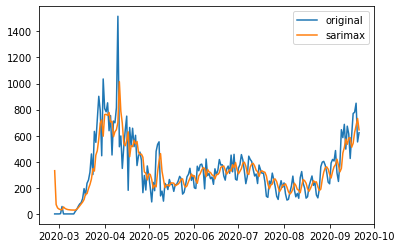

In [15]:
plt.plot(data_dgs_df_confirmed_detrend, label='original')
plt.plot(data_dgs_df_confirmed_detrend.index, sarimax.predict_in_sample(), label='sarimax')
plt.legend()

In [17]:
from sklearn.metrics import mean_absolute_error

predictions = sarimax.predict_in_sample()
mae = mean_absolute_error(predictions, data_dgs_df_confirmed_detrend)

In [18]:
mae

91.55847680825788

In [26]:
import numpy as np

sarimax_forecast_one_step_refit = []
# forecast next 60 days
for i in np.arange(0,60):
    next_step_forecast = sarimax.predict(1)[0]
    sarimax_forecast_one_step_refit.append(next_step_forecast)
    sarimax = sarimax.update(data_dgs_df_confirmed_detrend[i:i+1])

/Users/inesmendes/miniconda3/envs/forecast/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/inesmendes/miniconda3/envs/forecast/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/inesmendes/miniconda3/envs/forecast/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/inesmendes/miniconda3/envs/forecast/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed

/Users/inesmendes/miniconda3/envs/forecast/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/inesmendes/miniconda3/envs/forecast/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/inesmendes/miniconda3/envs/forecast/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/inesmendes/miniconda3/envs/forecast/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed

<AxesSubplot:>

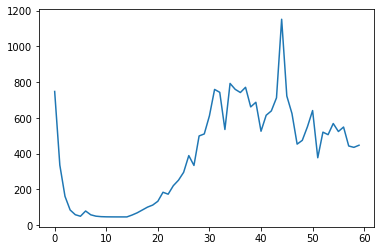

In [27]:
pd.Series(sarimax_forecast_one_step_refit).plot()

<AxesSubplot:>

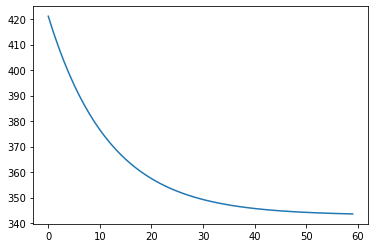

In [28]:
forecast = sarimax.predict(60)
pd.Series(forecast).plot()
